# Network visualization

This notebook constructs a network visualization connecting bacterial apecies to metabolic compounds.

In [2]:
# Preliminaries
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def widen_notebook():
    display(HTML("<style>.container { width:100% !important; }</style>"))
widen_notebook()

In [3]:
# data files
!ls ../data/edges

hfd         ihmp        lung-cancer


In [4]:
edges_txt = "../data/edges/lung-cancer/edges.txt"
metabolites_txt = "../data/edges/lung-cancer/metabolite_metadata.txt"
microbes_txt = "../data/edges/lung-cancer/microbe_metadata.txt"

In [4]:
# Read data files into lists of dictionaries
def split_commas(line):
    return line.strip().split("\t")

def CSVtodicts(filename):
    f = open(filename)
    result = []
    headers = split_commas(f.readline())
    for line in f.readlines():
        values = split_commas(line)
        dictionary = dict(zip(headers, values))
        result.append(dictionary)
    return result

edges = CSVtodicts(edges_txt)
metabolites = CSVtodicts(metabolites_txt)
microbes = CSVtodicts(microbes_txt)

len(edges), len(metabolites), len(microbes)

(1000, 40886, 562)

In [5]:
import pandas as pd
microbes = pd.read_table(microbes_txt)
metabolites = pd.read_table(metabolites_txt)
edges = pd.read_table(edges_txt)

/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jmorton/miniconda3/envs/jpnetviz/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [6]:
d_col = 'diagnosis[T.nonIBD]'
ew = "cond_logit"

In [7]:
select_microbes = list(set(edges.microbe.values))
select_metabolite = list(set(edges.metabolite.values))

In [8]:
import seaborn as sns

In [9]:
np.min(microbes.set_index('featureid').loc[select_microbes, d_col].values), np.max(microbes.set_index('featureid').loc[select_microbes, d_col].values)

(-4.981092279916132, 0.4954411330172164)

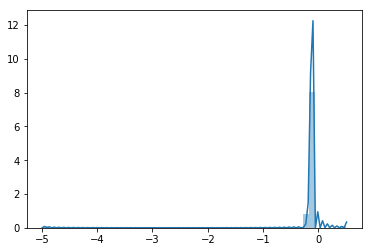

In [10]:
sns.distplot(microbes.set_index('featureid').loc[select_microbes, d_col].values)

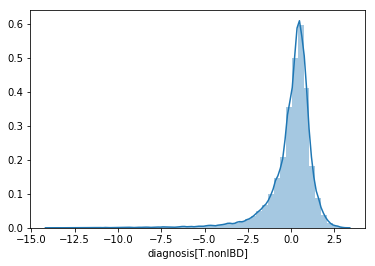

In [11]:
sns.distplot(metabolites[d_col])

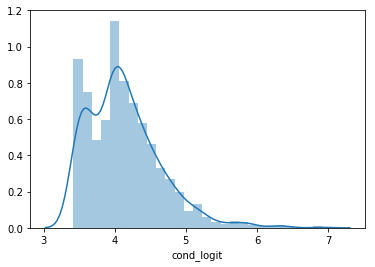

In [12]:
sns.distplot(edges[ew])

In [13]:
def abbreviate(x):
    return x.split('|')[-1]
abbreviate('k__Viruses|p__Viruses_noname|c__Viruses_noname|o__Viruses_noname')

'o__Viruses_noname'

In [14]:
microbe_dicts = microbes.T.to_dict().values()
metabolite_dicts = metabolites.T.to_dict().values()
edge_dicts = edges.T.to_dict().values()


# name abbreviation mappings.
def microbe_name_dict(dicts):
    return dict([abbreviate(d['featureid']), d] for d in dicts)

name2microbe = microbe_name_dict(microbe_dicts)
name2microbe.items()[15]

('t__GCF_000160055',
 {'Intercept': 0.7716171453007581,
  'diagnosis[T.UC]': 0.16910393636846166,
  'diagnosis[T.nonIBD]': 0.15264480733362262,
  'featureid': 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus|t__GCF_000160055'})

In [15]:
def metabolite_name_dict(dicts):
    #def f(x):
    #if x['Metabolite'] == '':
    #    return x['sampleid']
    #else:
    #    return x['Metabolite']
    return dict([abbreviate(d['sampleid']), d] for d in dicts)

In [16]:
name2metabolite = metabolite_name_dict(metabolite_dicts)
name2metabolite.items()[32]

('C8p_QI28355',
 {'HMDB (*Representative ID)': nan,
  'Intercept': -0.90594426035425,
  'Metabolite': nan,
  'Method': 'C8-pos',
  'Pooled QC sample CV': 0.510418331,
  'RT': 3.29,
  'diagnosis[T.UC]': -4.415580539094426,
  'diagnosis[T.nonIBD]': -1.0232884099782105,
  'm/z': 940.5417,
  'sampleid': 'C8p_QI28355'})

In [17]:
# Construct the network graph from the edges.
from jp_gene_viz import dGraph
G = dGraph.WGraph()
for e in edge_dicts:
    G.add_edge(abbreviate(e["microbe"]), abbreviate(e["metabolite"]), e[ew], e)

In [18]:
# Construct the network widget from the graph
from jp_gene_viz import dNetwork
dNetwork.load_javascript_support()
N = dNetwork.NetworkDisplay()
N.load_data(G)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import matplotlib as mpl
from matplotlib.colors import rgb2hex
cmap = plt.get_cmap('RdYlGn')
microbe_norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.1)
metabolite_norm = mpl.colors.Normalize(vmin=-2, vmax=2)

In [20]:
# Configure and display the network

N.labels_button.value = True
N.size_slider.value = 1000

# colorize the nodes based on weights (hacky, sorry)
dg = N.display_graph
for node_name in dg.node_weights:
    svg_name = dg.node_name(node_name)
    if node_name in name2metabolite:
        d = name2metabolite[node_name]
        value = d[d_col]
        N.color_overrides[svg_name] = rgb2hex(cmap(metabolite_norm(value))[:3])
        #N.color_overrides[svg_name] = metabolite_colorizer.interpolate_color(value)
        #print svg_name, N.color_overrides[svg_name]
        #break
    else:
        d = name2microbe[node_name]        
        value = d[d_col]
        N.color_overrides[svg_name] = rgb2hex(cmap(microbe_norm(value))[:3])
        #N.color_overrides[svg_name] = microbe_colorizer.interpolate_color(value)

N.draw()
N.show()

SEJveChjaGlsZHJlbj0oVkJveChjaGlsZHJlbj0oRHJvcGRvd24obGF5b3V0PUxheW91dCh3aWR0aD11JzE1MHB4JyksIG9wdGlvbnM9KCdTVkcnLCAnY2FudmFzJyksIHZhbHVlPSdTVkcnKSzigKY=
